# Classification Models

## 1. Models Investigated

We prepared 6 different models to test on the ResNet50 architecutre as well as the VGG16 architecture. The models are trained on different partitions and subgroups of the DDSM dataset. The models are:
- Model 0: Raw Pre-Processed DDSM Dataset (Baseline)
    - This model uses all of the data available in the DDSM data set that we selected.
- Model 1: Cleaned Normal Class
    - This model, as discussed in the EDA tab, trains on a dataset where the noisy images (black background and labels) have been removed.
- Model 2: Classification of Abnormalities (Classes 1 to 4)
    - This model trains on the dataset where the "normal" class images have been removed and strictly classifies the different types of abnormalities.
- Model 3: Normal vs Abnormal (Class 0 vs 1-4)
    - This model reduces all the abnormal images to one class and attempts to distinguish between the normal and abnormal images.
- Model 4: Benign vs Malignant Calcification
    - This model looks strictly at the original class 1 and class 3, which are benign and malignant calcifications.
- Model 5: Benign vs Malignant Mass
    - This model looks strictly at the original class 2 and 4, which are benign and malignant masses.
    
We evaluate each model on the training data, the RGB test data, and the grayscale test data. We originally were only using the RGB test data, but because we had such low test accuracy, we worried that the Keras ImageDataGenerator converted the image to RGB in a different way than tf.image.grayscale_to_rgb did, so we saved the images as grayscale and repeated the process. Everything is in this notebook, but note this was a classic "it's the data science process!" moment where we had to take several steps back and try again.

A summary of the training and test accuracies can be found at the conclusion.

In [1]:
'''IMPORT LIBRARIES'''
import requests
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
# import cv2

from scipy.misc import imresize
from sklearn.model_selection import train_test_split

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.layers import Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D
from keras.layers import Cropping2D, Conv2DTranspose, BatchNormalization, Activation, GlobalAveragePooling2D
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.preprocessing import image
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import random
import keras

import json

from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

np.random.seed(42)

Using TensorFlow backend.


## 2. Loading the Data

The data was prepared into CSV files that were formated to have the file name and the class labels. The code for this can be found in the EDA tab.

The validation data for training is randomly sampled from the training dataset during model creation, since that is when the data generators are created.

In [2]:
train_df_model_0 = pd.read_csv('data/train_df_model_0.csv')
train_df_model_1 = pd.read_csv('data/train_df_model_1.csv')
train_df_model_2 = pd.read_csv('data/train_df_model_2.csv')
train_df_model_3 = pd.read_csv('data/train_df_model_3.csv')
train_df_model_4 = pd.read_csv('data/train_df_model_4.csv')
train_df_model_5 = pd.read_csv('data/train_df_model_5.csv')

In [3]:
test_df_model_0 = pd.read_csv("data/test_df_model_0.csv")
test_df_model_1 = pd.read_csv("data/test_df_model_1.csv")
test_df_model_2 = pd.read_csv("data/test_df_model_2.csv")
test_df_model_3 = pd.read_csv("data/test_df_model_3.csv")
test_df_model_4 = pd.read_csv("data/test_df_model_4.csv")
test_df_model_5 = pd.read_csv("data/test_df_model_5.csv")
test_dfs = [test_df_model_0, test_df_model_1, test_df_model_2, test_df_model_3, test_df_model_4, test_df_model_5]

## 3. Setting Up the Models

We will use transfer learning on the pre-trained CCN networks (ResNet will be compared to VGG). We define several hyper-parameters for each model, and define functions to build the data generators and the model, and to evaluate them.

In [4]:
'''HYPER-PARAMETERS'''
#Architecture
architect = 0 #0: Resnet50, 1:VGG
if architect == 0:
    arch_name = 'resnet50'
elif architect == 1:
    arch_name = 'vgg16'

#Image related parameters
H = 299
W = 299
n_channels = 3

#Optimization related parameters
batch_size_train = 32
batch_size_test  = 1

#Model related parameters
model0_epochs = 10
model1_epochs = 5
model2_epochs = 20
model3_epochs = 5
model4_epochs = 20
model5_epochs = 20

model0_classes = 5
model1_classes = 5
model2_classes = 4
model3_classes = 2
model4_classes = 2
model5_classes = 2

In [5]:
'''Build the model and DataGenerators.'''
def build_model(n_classes,df,architecture=0,x='filename',y='y', bs_train = 32, lr = 0.0001,H = H,W = W, n_channels = 3):
    #Data generator
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[y])
    val_df.reset_index(inplace=True)
    val_df.drop(['index'], axis=1, inplace=True)
    train_datagen = ImageDataGenerator(
            rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_dataframe(
        directory='images',
        dataframe=train_df,
        x_col=x,
        y_col=y,
        # width by height only, not channels
        target_size=(H, W),
        color_mode="rgb",
        batch_size=bs_train,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        directory='images',
        dataframe=val_df,
        x_col=x,
        y_col=y,
        # width by height only, not channels
        target_size=(H, W),
        color_mode="rgb",
        batch_size=bs_train,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )
    #Class weight
    all_classes = df[y].unique()
    class_weights = compute_class_weight(class_weight='balanced', classes=all_classes, y=train_df[y])
    #Model architecture
    inp = Input(shape = (H,W,n_channels))
    
    if architecture == 0:
        model = ResNet50(input_shape=(H,W,n_channels), include_top=False, weights='imagenet')
    elif architecture ==1:
        model = VGG16(input_shape=(H,W,n_channels), include_top=False, weights='imagenet')
    x1 = model(inp)
    x2 = GlobalAveragePooling2D()(x1)
    out = Dense(n_classes, activation='softmax')(x2)

    model = Model(inputs = inp, outputs = out)
    optimizer = Adam(lr=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
    STEP_SIZE_VAL = val_generator.n//val_generator.batch_size
        
    return model, train_generator, val_generator, class_weights, STEP_SIZE_TRAIN, STEP_SIZE_VAL

In [6]:
'''Build test DataGenerators for the RGB data.'''
test_gens = {}
for i, df in zip(range(6), test_dfs):
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    test_generator = test_datagen.flow_from_dataframe(
        directory='test_images/',
        dataframe=df,
        x_col='filename',
        y_col='y',
        # width by height only, not channels
        target_size=(H, W),
        color_mode="rgb",
        batch_size=batch_size_test,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )
    test_gens[i] = test_generator

Found 15364 images belonging to 5 classes.
Found 15364 images belonging to 5 classes.
Found 2004 images belonging to 4 classes.
Found 15364 images belonging to 2 classes.
Found 927 images belonging to 2 classes.
Found 1077 images belonging to 2 classes.


In [7]:
'''Build test DataGenerators for the grayscale data.'''
test_gens_gray = {}
for i, df in zip(range(6), test_dfs):
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    test_generator = test_datagen.flow_from_dataframe(
        directory='test_images_grayscale/',
        dataframe=df,
        x_col='filename',
        y_col='y',
        # width by height only, not channels
        target_size=(H, W),
        color_mode="rgb",
        batch_size=batch_size_test,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )
    test_gens_gray[i] = test_generator

Found 15364 images belonging to 5 classes.
Found 15364 images belonging to 5 classes.
Found 2004 images belonging to 4 classes.
Found 15364 images belonging to 2 classes.
Found 927 images belonging to 2 classes.
Found 1077 images belonging to 2 classes.


In [8]:
'''Evaluate a given model on test and training data.'''
def evaluate_train_test(model, train_gen=None, step_size_train=None, test_gen=None):
    train_results = None
    if train_gen:
        train_results = model.evaluate_generator(train_gen, steps=step_size_train)
    test_results = None
    if test_gen:
        test_results = model.evaluate_generator(test_gen, test_gen.n)
    return train_results, test_results

In [9]:
'''Format evaluation metrics from both a best weights model and a final model.'''
def pretty_metrics(model_id, model_best_weights_train, model_best_weights_test):
    if model_best_weights_train and model_best_weights_test:
        bw_train_loss, bw_train_acc = model_best_weights_train
        bw_test_loss, bw_test_acc = model_best_weights_test
        results = pd.DataFrame()
        results['Model'] = ['Best Weights Model {}'.format(model_id)]
        results['training loss'] = [bw_train_loss]
        results['training acc'] = [bw_train_acc]
        results['test loss'] = [bw_test_loss]
        results['test acc'] = [bw_test_acc]
        return results
    return None

In [10]:
'''Save the model weights and history'''
def save_all(model,model_history,model_name,arch_name):
    #Save model and weights
    model.save('models/'+arch_name+'_'+model_name+'.h5')
    model.save_weights('models/'+arch_name+'_'+model_name+'_weights.h5')

    #save history
    with open(arch_name+'_'+model_name+'_history.json', 'w') as f:
        json.dump(model_history.history, f)

In [14]:
def load_all(model_name,arch_name,bw=False):
    if bw:
        model_best_weights = load_model('models/'+arch_name+'_'+model_name+'_best_weights.h5')
        return model_best_weights
    else:
        model_best_weights = load_model('models/'+arch_name+'_'+model_name+'_best_weights.h5')
        model = load_model('models/'+arch_name+'_'+model_name+'.h5')
        with open(arch_name+'_'+model_name+'_history.json') as json_file:  
            model_history = json.load(json_file)
        return model,model_best_weights,model_history

In [12]:
def plot_train(model_history,title):
    fontsize = 20
    fig = plt.figure(figsize=(20,5))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    ax0.plot(model_history['acc'],label='train accuracy')
    ax0.plot(model_history['val_acc'],label='val accuracy')
    ax0.set_xlabel('Epochs',fontsize=fontsize)
    ax0.set_ylabel('Accuracy',fontsize=fontsize)
    ax0.legend();
    ax1.plot(model_history['loss'],label='train loss')
    ax1.plot(model_history['val_loss'],label='val loss')
    ax1.set_xlabel('Epochs',fontsize=fontsize)
    ax1.set_ylabel('Loss',fontsize=fontsize)
    ax1.legend();
    plt.suptitle(title,y=0.95,fontsize=fontsize);

## 4. Model Training on ResNet50

First, we use the ResNet50 architecture to train all models. We will report our optimal train accuracy which is based on the maximum cross-validation accuracy as a function of the number of epoch.

### Model 0: Raw Pre-Processed DDSM Dataset (Baseline)

The baseline model classifies the images from the pre-processed DDSM dataset into the following $5$ classes:

- $0$: Normal
- $1$: Benign Calcification
- $2$: Benign Mass
- $3$: Malignant Calcification
- $4$: Malignant Mass

In [17]:
model_0, train_generator_0, val_generator_0, class_weights_0, STEP_SIZE_TRAIN_0, STEP_SIZE_VAL_0 = \
    build_model(model0_classes,
                train_df_model_0,
                architecture = 0,
                x='filename',
                y='y', 
                bs_train = 32, 
                lr = 0.0001,
                H = H,
                W = W,
                n_channels = 3)

/usr/share/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Found 44708 images belonging to 5 classes.
Found 11177 images belonging to 5 classes.


/usr/share/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [28]:
%%time
model_0_name = 'model_0'
filepath_0="models/"+arch_name+"_"+model_0_name+"_best_weights.h5"
checkpoint_0 = ModelCheckpoint(filepath_0, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list_0 = [checkpoint_0]

model_0_history=model_0.fit_generator(generator=train_generator_0,
                    class_weight = class_weights_0,
                    steps_per_epoch=STEP_SIZE_TRAIN_0,
                    validation_data = val_generator_0,
                    validation_steps = STEP_SIZE_VAL_0,
                    epochs=model0_epochs,
                    callbacks=callbacks_list_0

)

Epoch 1/10
1397/1397 [==============================] - 2414s 2s/step - loss: 0.2245 - acc: 0.9199 - val_loss: 1.5668 - val_acc: 0.4781

Epoch 00001: val_acc improved from -inf to 0.47806, saving model to models/resnet50_model_0_best_weights.h5
Epoch 2/10
1397/1397 [==============================] - 2383s 2s/step - loss: 0.1515 - acc: 0.9432 - val_loss: 0.3199 - val_acc: 0.9046

Epoch 00002: val_acc improved from 0.47806 to 0.90462, saving model to models/resnet50_model_0_best_weights.h5
Epoch 3/10
1397/1397 [==============================] - 2397s 2s/step - loss: 0.1144 - acc: 0.9577 - val_loss: 0.4617 - val_acc: 0.8474

Epoch 00003: val_acc did not improve from 0.90462
Epoch 4/10
1397/1397 [==============================] - 2300s 2s/step - loss: 0.0865 - acc: 0.9673 - val_loss: 2.3846 - val_acc: 0.4676

Epoch 00004: val_acc did not improve from 0.90462
Epoch 5/10
1397/1397 [==============================] - 2271s 2s/step - loss: 0.0657 - acc: 0.9761 - val_loss: 0.3797 - val_acc: 0.87

In [29]:
save_all(model_0,model_0_history,model_0_name,arch_name)

In [15]:
%%time
model_0_name = 'model_0'
# model_0,model_0_best_weights,model_0_history = load_all(model_0_name,arch_name)
model_0_best_weights = load_all(model_0_name,arch_name,True)

CPU times: user 32.1 s, sys: 1.41 s, total: 33.5 s
Wall time: 38.8 s


#### Model 0 Evaluation

Let us plot the accuracy and loss on the train and cross-validation set as a function of the number of epochs.

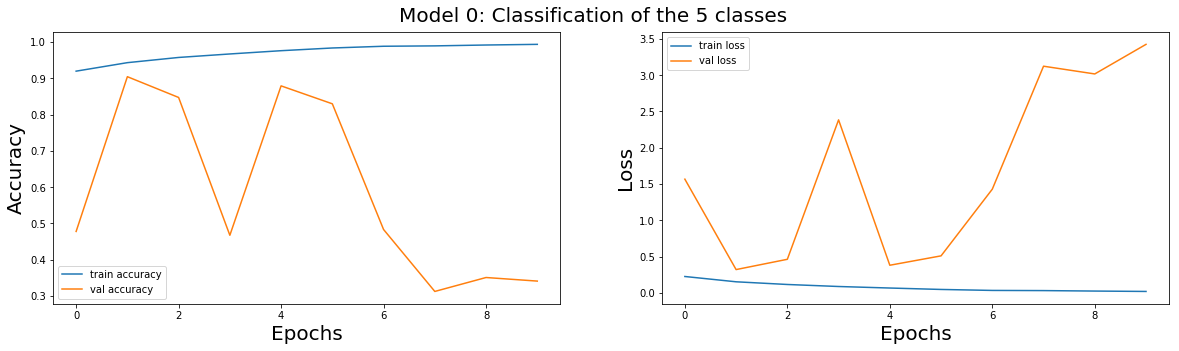

In [32]:
plot_train(model_0_history,'Model 0: Classification of the 5 classes')

First we evaluate the models with the RGB test data.

In [18]:
%%time
model_0_bw_train_metrics, model_0_bw_test_metrics = evaluate_train_test(model_0_best_weights, 
                                                                        train_generator_0, 
                                                                        STEP_SIZE_TRAIN_0, 
                                                                        test_gens[0])

CPU times: user 37min 15s, sys: 5min 44s, total: 43min
Wall time: 21min 40s


In [19]:
model_0_results = pretty_metrics(0, 
                                 model_0_bw_train_metrics, 
                                 model_0_bw_test_metrics)
display(model_0_results)

,Model,training loss,training acc,test loss,test acc
0,Best Weights Model 0,0.284514,0.918173,1.555544,0.758657


Now we evaluate the model only on the grayscale test data. We see that the results are identical to the results for the RGB test data, so we do not reproduce this analysis for the remaining models.

In [36]:
%%time
_ , model_0_gray_test = evaluate_train_test(model_0, test_gen=test_gens_gray[0])
_ , bw_model_0_gray_test = evaluate_train_test(model_0_best_weights, test_gen=test_gens_gray[0])

CPU times: user 16min 52s, sys: 5min 4s, total: 21min 56s
Wall time: 18min 39s


In [37]:
pd.DataFrame({'metric': ['test loss', 'test acc'],
              'Model 0 Best Weights':bw_model_0_gray_test})

,metric,Model 0,Model 0 Best Weights
0,test loss,4.248569,1.557154
1,test acc,0.281047,0.758526


### Model  1: Cleaned Normal Class

In [20]:
model_1, train_generator_1, val_generator_1, class_weights_1, STEP_SIZE_TRAIN_1, STEP_SIZE_VAL_1 = \
    build_model(model1_classes,
                train_df_model_1,
                architecture=0,
                x='filename',
                y='y', 
                bs_train = 32, 
                lr = 1.1111,
                H = H,
                W = W,
                n_channels = 3)

/usr/share/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Found 42261 images belonging to 5 classes.
Found 10566 images belonging to 5 classes.


/usr/share/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
%%time
model_1_name = 'model_1'
filepath_1="models/"+arch_name+"_"+model_1_name+"_best_weights.h5"
checkpoint_1 = ModelCheckpoint(filepath_1, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list_1 = [checkpoint_1]

model_1_history = model_1.fit_generator(generator=train_generator_1,
                    class_weight = class_weights_1,
                    steps_per_epoch=STEP_SIZE_TRAIN_1,
                    validation_data = val_generator_1,
                    validation_steps = STEP_SIZE_VAL_1,
                    epochs=model1_epochs,
                    callbacks=callbacks_list_1
)

Epoch 1/5
1320/1320 [==============================] - 2170s 2s/step - loss: 2.2231 - acc: 0.8616 - val_loss: 2.2239 - val_acc: 0.8620

Epoch 00001: val_acc improved from -inf to 0.86203, saving model to models/resnet50_model_1_best_weights.h5
Epoch 2/5
 710/1320 [===============>..............] - ETA: 15:15 - loss: 2.2117 - acc: 0.8628

In [ ]:
save_all(model_1,model_1_history,model_1_name,arch_name)

In [21]:
%%time
model_1_name = 'model_1'
# model_1,model_1_best_weights,model_1_history = load_all(model_1_name,arch_name)
model_1_best_weights = load_all(model_1_name,arch_name,True)

CPU times: user 59.4 s, sys: 364 ms, total: 59.8 s
Wall time: 1min 1s


#### Model 1 Evaluation

The training of model $1$ was interrupted by a sudden loss of connection with the Jupyter Hub server. Therefore, while we have save the model with the best weights, the history was not saved in order to plot the accuracy and loss vs number of epochs.

In [ ]:
# plot_train(model_1_history,'Model 1: Classification of the 5 cleaned classes')

We can evaluate the model on the test set.

In [22]:
%%time
model_1_bw_train_metrics, model_1_bw_test_metrics = evaluate_train_test(model_1_best_weights, 
                                                                        train_generator_1, 
                                                                        STEP_SIZE_TRAIN_1, 
                                                                        test_gens[1])

CPU times: user 36min 49s, sys: 5min 13s, total: 42min 3s
Wall time: 21min 33s


In [23]:
model_1_results = pretty_metrics(1, 
                                 model_1_bw_train_metrics, 
                                 model_1_bw_test_metrics)
display(model_1_results)

,Model,training loss,training acc,test loss,test acc
0,Best Weights Model 1,2.22387,0.862027,2.10236,0.869565


### Model 2: Classification of Abnormalities (Classes 1 to 4)

In [30]:
model_2, train_generator_2, val_generator_2, class_weights_2, STEP_SIZE_TRAIN_2, STEP_SIZE_VAL_2 = \
    build_model(model2_classes,
                train_df_model_2,
                architecture=0,
                x='filename',
                y='y', 
                bs_train = 32, 
                lr = 0.0001,
                H = H,
                W = W, 
                n_channels = 3)

/usr/share/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Found 5831 images belonging to 4 classes.
Found 1458 images belonging to 4 classes.


/usr/share/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [15]:
%%time
model_2_name = 'model_2'
filepath_2="models/"+arch_name+"_"+model_2_name+"_best_weights.h5"
checkpoint_2 = ModelCheckpoint(filepath_2, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list_2 = [checkpoint_2]

model_2_history = model_2.fit_generator(generator=train_generator_2,
                    class_weight = class_weights_2,
                    steps_per_epoch=STEP_SIZE_TRAIN_2,
                    validation_data = val_generator_2,
                    validation_steps = STEP_SIZE_VAL_2,
                    epochs=model2_epochs,
                    callbacks=callbacks_list_2

)

Epoch 1/20
182/182 [==============================] - 323s 2s/step - loss: 0.9912 - acc: 0.5726 - val_loss: 1.3421 - val_acc: 0.3028

Epoch 00001: val_acc improved from -inf to 0.30278, saving model to models/resnet50_model_2_best_weights.h5
Epoch 2/20
182/182 [==============================] - 305s 2s/step - loss: 0.6409 - acc: 0.7332 - val_loss: 1.8454 - val_acc: 0.2910

Epoch 00002: val_acc did not improve from 0.30278
Epoch 3/20
182/182 [==============================] - 302s 2s/step - loss: 0.3885 - acc: 0.8469 - val_loss: 3.0226 - val_acc: 0.2356

Epoch 00003: val_acc did not improve from 0.30278
Epoch 4/20
182/182 [==============================] - 302s 2s/step - loss: 0.2016 - acc: 0.9285 - val_loss: 3.7270 - val_acc: 0.3499

Epoch 00004: val_acc improved from 0.30278 to 0.34993, saving model to models/resnet50_model_2_best_weights.h5
Epoch 5/20
182/182 [==============================] - 302s 2s/step - loss: 0.1715 - acc: 0.9389 - val_loss: 3.6852 - val_acc: 0.2812

Epoch 00005

In [16]:
save_all(model_2,model_2_history,model_2_name,arch_name)

In [31]:
%%time
model_2_name = 'model_2'
# model_2,model_2_best_weights,model_2_history = load_all(model_2_name,arch_name)
model_2_best_weights = load_all(model_2_name,arch_name,True)

CPU times: user 2min 10s, sys: 96 ms, total: 2min 10s
Wall time: 2min 10s


#### Model 2 Evaluation

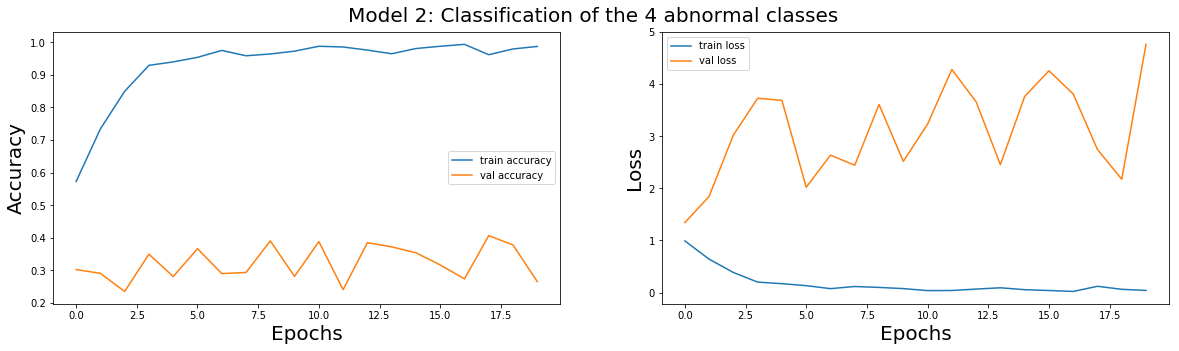

In [18]:
plot_train(model_2_history,'Model 2: Classification of the 4 abnormal classes')

In [32]:
%%time
model_2_bw_train_metrics, model_2_bw_test_metrics = evaluate_train_test(model_2_best_weights, 
                                                                        train_generator_2, 
                                                                        STEP_SIZE_TRAIN_2, 
                                                                        test_gens[2])

CPU times: user 5min 44s, sys: 41.7 s, total: 6min 25s
Wall time: 3min 26s


In [34]:
model_2_results = pretty_metrics(2,
                                 model_2_bw_train_metrics, 
                                 model_2_bw_test_metrics)
display(model_2_results)

,Model,training loss,training acc,test loss,test acc
0,Best Weights Model 2,1.110618,0.658482,3.022887,0.251996


### Model 3: Normal vs Abnormal (Class 0 vs 1-4)

In [26]:
model_3, train_generator_3, val_generator_3, class_weights_3, STEP_SIZE_TRAIN_3, STEP_SIZE_VAL_3 = \
    build_model(model3_classes,
                train_df_model_3,
                architecture=0,
                x='filename',
                y='y', 
                bs_train = 32, 
                lr = 0.0001,
                H = H,
                W = W, 
                n_channels = 3)

/usr/share/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Found 42261 images belonging to 2 classes.
Found 10566 images belonging to 2 classes.


/usr/share/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [20]:
%%time
model_3_name = 'model_3'
filepath_3="models/"+arch_name+"_"+model_3_name+"_best_weights.h5"
checkpoint_3 = ModelCheckpoint(filepath_3, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list_3 = [checkpoint_3]

model_3_history = model_3.fit_generator(generator=train_generator_3,
                    class_weight = class_weights_3,
                    steps_per_epoch=STEP_SIZE_TRAIN_3,
                    validation_data = val_generator_3,
                    validation_steps = STEP_SIZE_VAL_3,
                    epochs=model3_epochs,
                    callbacks=callbacks_list_3
)

Epoch 1/5
1320/1320 [==============================] - 2232s 2s/step - loss: 0.1032 - acc: 0.9588 - val_loss: 0.5071 - val_acc: 0.7451

Epoch 00001: val_acc improved from -inf to 0.74508, saving model to models/resnet50_model_3_best_weights.h5
Epoch 2/5
  49/1320 [>.............................] - ETA: 33:42 - loss: 0.0444 - acc: 0.9815

KeyboardInterrupt: 

In [ ]:
save_all(model_3,model_3_history,model_3_name,arch_name)

In [27]:
%%time
model_3_name = 'model_3'
# model_3,model_3_best_weights,model_3_history = load_all(model_3_name,arch_name)
model_3_best_weights = load_all(model_3_name,arch_name,True)

CPU times: user 1min 36s, sys: 260 ms, total: 1min 36s
Wall time: 1min 38s


#### Model 3 Evaluation
The training of model $3$ was interrupted by a sudden loss of connection with the Jupyter Hub server. Therefore, while we have save the model with the best weights, the history was not saved in order to plot the accuracy and loss vs number of epochs.

In [ ]:
# plot_train(model_3_history,'Model 3: Classification of the abnormal vs normal images')

In [28]:
%%time
model_3_bw_train_metrics, model_3_bw_test_metrics = evaluate_train_test(model_3_best_weights, 
                                                                        train_generator_3, 
                                                                        STEP_SIZE_TRAIN_3, 
                                                                        test_gens[3])

CPU times: user 39min 12s, sys: 5min 15s, total: 44min 28s
Wall time: 22min 57s


In [29]:
model_3_results = pretty_metrics(3, 
                                 model_3_bw_train_metrics, 
                                 model_3_bw_test_metrics)
display(model_3_results)

,Model,training loss,training acc,test loss,test acc
0,Best Weights Model 3,0.499556,0.750047,1.309038,0.59685


Now we evaluate the model only on the grayscale test data. Again, the results are identical to the RGB image results.

### Model 4: Benign vs Malignant Calcification

In [35]:
model_4, train_generator_4, val_generator_4, class_weights_4, STEP_SIZE_TRAIN_4, STEP_SIZE_VAL_4 = \
    build_model(model4_classes,
                train_df_model_4,
                architecture=0,
                x='filename',
                y='y', 
                bs_train = 32, 
                lr = 0.0001,
                H = H,
                W = W, 
                n_channels = 3)

/usr/share/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Found 2852 images belonging to 2 classes.
Found 714 images belonging to 2 classes.


/usr/share/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
%%time
model_4_name = 'model_4'
filepath_4="models/"+arch_name+"_"+model_4_name+"_best_weights.h5"
checkpoint_4 = ModelCheckpoint(filepath_4, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list_4 = [checkpoint_4]

model_4_history = model_4.fit_generator(generator=train_generator_4,
                    class_weight = class_weights_4,
                    steps_per_epoch=STEP_SIZE_TRAIN_4,
                    validation_data = val_generator_4,
                    validation_steps = STEP_SIZE_VAL_4,
                    epochs=model4_epochs,
                    callbacks=callbacks_list_4
)

In [26]:
save_all(model_4,model_4_history,model_4_name,arch_name)

In [36]:
%%time
model_4_name = 'model_4'
# model_4,model_4_best_weights,model_4_history = load_all(model_4_name,arch_name)
model_4_best_weights = load_all(model_4_name,arch_name,True)

CPU times: user 2min 50s, sys: 0 ns, total: 2min 50s
Wall time: 2min 51s


#### Model 4 Evaluation

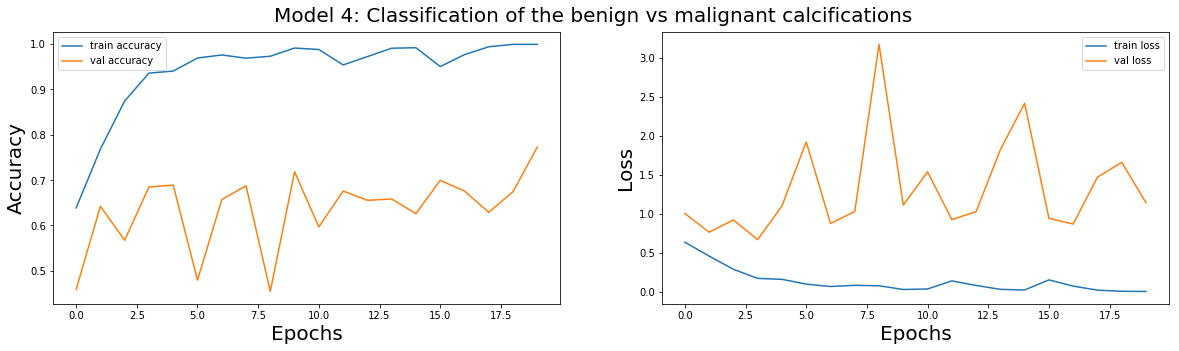

In [39]:
plot_train(model_4_history,'Model 4: Classification of the benign vs malignant calcifications')

In [37]:
%%time
model_4_bw_train_metrics, model_4_bw_test_metrics = evaluate_train_test(model_4_best_weights, 
                                                                        train_generator_4, 
                                                                        STEP_SIZE_TRAIN_4, 
                                                                        test_gens[4])

CPU times: user 3min 5s, sys: 19.9 s, total: 3min 25s
Wall time: 1min 57s


In [38]:
model_4_results = pretty_metrics(4,
                                 model_4_bw_train_metrics, 
                                 model_4_bw_test_metrics)
display(model_4_results)

,Model,training loss,training acc,test loss,test acc
0,Best Weights Model 4,0.00322,0.999298,1.889246,0.523193


### Model 5: Benign vs Malignant Mass

In [39]:
model_5, train_generator_5, val_generator_5, class_weights_5, STEP_SIZE_TRAIN_5, STEP_SIZE_VAL_5 = \
    build_model(model5_classes,
                train_df_model_5,
                architecture=0,
                x='filename',
                y='y', 
                bs_train = 32, 
                lr = 0.0001,
                H = H,
                W = W, 
                n_channels = 3)

/usr/share/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Found 2978 images belonging to 2 classes.
Found 745 images belonging to 2 classes.


/usr/share/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [49]:
%%time
model_5_name = 'model_5'
filepath_5="models/"+arch_name+"_"+model_5_name+"_best_weights.h5"
checkpoint_5 = ModelCheckpoint(filepath_5, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list_5 = [checkpoint_5]

model_5_history = model_5.fit_generator(generator=train_generator_5,
                    class_weight = class_weights_5,
                    steps_per_epoch=STEP_SIZE_TRAIN_5,
                    validation_data = val_generator_5,
                    validation_steps = STEP_SIZE_VAL_5,
                    epochs=model5_epochs,
                    callbacks=callbacks_list_5

)

Epoch 1/20
93/93 [==============================] - 197s 2s/step - loss: 0.6166 - acc: 0.6744 - val_loss: 0.6310 - val_acc: 0.6658

Epoch 00001: val_acc improved from -inf to 0.66576, saving model to models/resnet50_model_5_best_weights.h5
Epoch 2/20
93/93 [==============================] - 156s 2s/step - loss: 0.4446 - acc: 0.7947 - val_loss: 1.0721 - val_acc: 0.5245

Epoch 00002: val_acc did not improve from 0.66576
Epoch 3/20
93/93 [==============================] - 154s 2s/step - loss: 0.2239 - acc: 0.9069 - val_loss: 0.6140 - val_acc: 0.6844

Epoch 00003: val_acc improved from 0.66576 to 0.68443, saving model to models/resnet50_model_5_best_weights.h5
Epoch 4/20
93/93 [==============================] - 154s 2s/step - loss: 0.1579 - acc: 0.9399 - val_loss: 0.7869 - val_acc: 0.6410

Epoch 00004: val_acc did not improve from 0.68443
Epoch 5/20
93/93 [==============================] - 154s 2s/step - loss: 0.0813 - acc: 0.9684 - val_loss: 0.6650 - val_acc: 0.7223

Epoch 00005: val_acc 

In [50]:
save_all(model_5,model_5_history,model_5_name,arch_name)

In [40]:
%%time
model_5_name = 'model_3'
# model_5,model_5_best_weights,model_5_history = load_all(model_5_name,arch_name)
model_5_best_weights = load_all(model_5_name,arch_name,True)

CPU times: user 3min 42s, sys: 0 ns, total: 3min 42s
Wall time: 3min 42s


#### Model 5 Evaluation

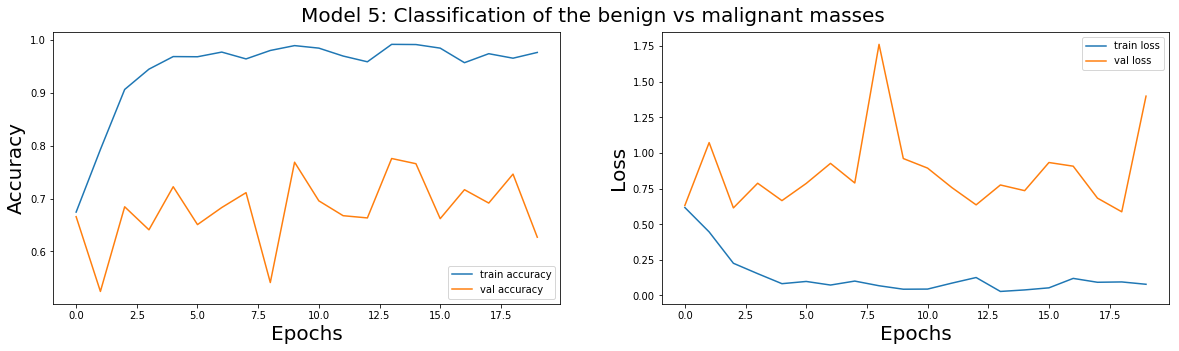

In [53]:
plot_train(model_5_history,'Model 5: Classification of the benign vs malignant masses')

In [41]:
%%time
model_5_bw_train_metrics, model_5_bw_test_metrics = evaluate_train_test(model_5_best_weights, 
                                                                        train_generator_5, 
                                                                        STEP_SIZE_TRAIN_5, 
                                                                        test_gens[5])

CPU times: user 3min 41s, sys: 22 s, total: 4min 3s
Wall time: 2min 20s


In [42]:
model_5_results = pretty_metrics(5,
                                 model_5_bw_train_metrics, 
                                 model_5_bw_test_metrics)
display(model_5_results)

,Model,training loss,training acc,test loss,test acc
0,Best Weights Model 5,1.679094,0.490255,1.696223,0.530176


Now we evaluate the model only on the grayscale test data. Again, the results are identical to the RGB image results.

### Summary of Results for Resnet50

Because the RGB and grayscale test data results were essentially the same, we simply show the test results from the RGB data.

In [44]:
all_results = pd.concat([model_0_results, 
                         model_1_results, model_2_results, model_3_results, model_4_results, model_5_results])
display(all_results)

,Model,training loss,training acc,test loss,test acc
0,Best Weights Model 0,0.284514,0.918173,1.555544,0.758657
0,Best Weights Model 1,2.223870,0.862027,2.102360,0.869565
0,Best Weights Model 2,1.110618,0.658482,3.022887,0.251996
0,Best Weights Model 3,0.499556,0.750047,1.309038,0.596850
0,Best Weights Model 4,0.003220,0.999298,1.889246,0.523193
0,Best Weights Model 5,1.679094,0.490255,1.696223,0.530176


### Analysis of the Results

As can be seen from the table above, there exist a clear gap between the very high training and very low test set accuracies for each model. Only models $0$ and $1$ have test accuracy above $75$% while the other models perform slightly better than random selection. This might indicate that we are over-fitting on the training set. However, as shown for models $0$, $4$, and $5$, the accuracy on the cross-validation is above $70$% and can even attain $90$% (model $0$). Only model $2$ seems to indicate over-fitting with very low accuracy on the cross-validation set with the number of epochs. To investigate if this low test accuracy is due to the model architecture, we try in the next section to tran model $2$ on the VGG16 architecture.

## 5. Model Training on VGG16
To investigate the influence of the CNN architecture, we train the model $2$ (classification of abnormalities) which had very low cross-validation accuracy on the VGG16 architecture with transfer learning coming from the _imagenet_ dataset. 

In [13]:
model_2, train_generator_2, val_generator_2, class_weights_2, STEP_SIZE_TRAIN_2, STEP_SIZE_VAL_2 = \
    build_model(model2_classes,
                train_df_model_2,
                architecture=1,
                x='filename',
                y='y', 
                bs_train = 32, 
                lr = 0.0001,
                H = H,
                W = W, 
                n_channels = 3)

/usr/share/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Found 5831 images belonging to 4 classes.
Found 1458 images belonging to 4 classes.


In [15]:
%%time
arch_name = 'vgg16'
model_2_name = 'model_2'
filepath_2="models/"+arch_name+"_"+model_2_name+"_best_weights.h5"
checkpoint_2 = ModelCheckpoint(filepath_2, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list_2 = [checkpoint_2]

model_2_history = model_2.fit_generator(generator=train_generator_2,
                    class_weight = class_weights_2,
                    steps_per_epoch=STEP_SIZE_TRAIN_2,
                    validation_data = val_generator_2,
                    validation_steps = STEP_SIZE_VAL_2,
                    epochs=model2_epochs,
                    callbacks=callbacks_list_2

)

Epoch 1/20
182/182 [==============================] - 333s 2s/step - loss: 1.3831 - acc: 0.2864 - val_loss: 1.3337 - val_acc: 0.3521

Epoch 00001: val_acc improved from -inf to 0.35208, saving model to models/vgg16_model_2_best_weights.h5
Epoch 2/20
182/182 [==============================] - 327s 2s/step - loss: 1.2391 - acc: 0.4343 - val_loss: 1.1615 - val_acc: 0.4306

Epoch 00002: val_acc improved from 0.35208 to 0.43058, saving model to models/vgg16_model_2_best_weights.h5
Epoch 3/20
182/182 [==============================] - 321s 2s/step - loss: 1.1046 - acc: 0.5008 - val_loss: 1.2196 - val_acc: 0.3899

Epoch 00003: val_acc did not improve from 0.43058
Epoch 4/20
182/182 [==============================] - 321s 2s/step - loss: 1.0721 - acc: 0.5132 - val_loss: 1.2054 - val_acc: 0.4670

Epoch 00004: val_acc improved from 0.43058 to 0.46704, saving model to models/vgg16_model_2_best_weights.h5
Epoch 5/20
182/182 [==============================] - 321s 2s/step - loss: 1.0133 - acc: 0.53

In [17]:
save_all(model_2,model_2_history,model_2_name,arch_name)

In [18]:
%%time
model_2,model_2_best_weights,model_2_history = load_all(model_2_name,arch_name)

CPU times: user 6.44 s, sys: 520 ms, total: 6.96 s
Wall time: 6.86 s


#### Model 2 on VGG16 Evaluation

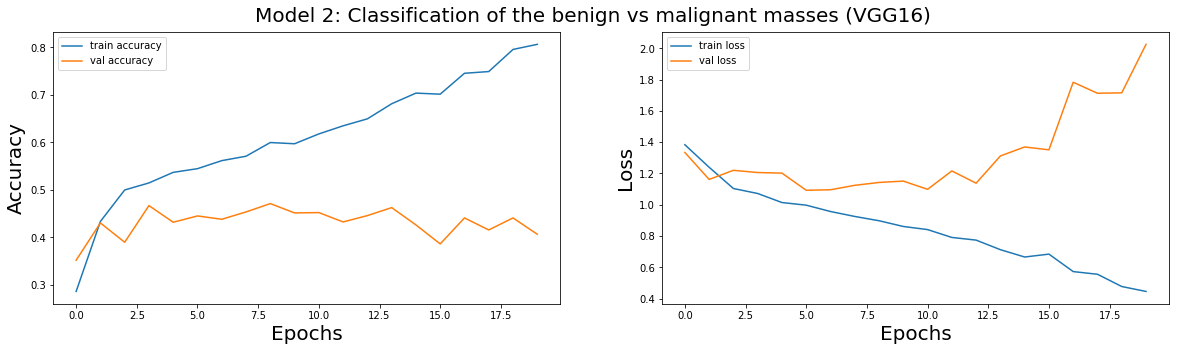

In [19]:
plot_train(model_2_history,'Model 2: Classification of the benign vs malignant masses (VGG16)')

In [20]:
%%time
model_2_vgg16_bw_train_metrics, model_2_vgg16_bw_test_metrics = evaluate_train_test(model_2_best_weights, 
                                                                        train_generator_2, 
                                                                        STEP_SIZE_TRAIN_2, 
                                                                        test_gens[2])

CPU times: user 4min 58s, sys: 54.6 s, total: 5min 52s
Wall time: 3min 4s


In [23]:
model_2_vgg16_results = pretty_metrics(2, model_2_vgg16_bw_train_metrics, 
                                 model_2_vgg16_bw_test_metrics)
display(model_2_vgg16_results)

,Model,training loss,training acc,test loss,test acc
0,Best Weights Model 2,0.877327,0.592516,1.875922,0.250998


The results using the VGG16 architecture on model $2$ are marginally better with the cross-validation accuracy averaging $40$%. However, the test accuracy remains very low with $25$% indicating that the classification model is guessing at a solution.

## 6. Conclusion

There results were not ideal because the accuracies are not comparable to what we've seen in the literature review. The fact that the validation accuracy and the test accuracy are not especially close is worrisome especially when the training data accuracy was so high durin training. This seems to indicate a problem with the data coming from the test dataset. Based on these results, we decided to perform interpretability methods on the training data.